In [1]:
import numpy as np
import pandas as pd
import healpy as hp
import GCRCatalogs
import os, sys
from GCR import GCRQuery
from sqlalchemy import create_engine
import mog_utils
import units
import matplotlib.pyplot as plt
from lsst.sims.utils import angularSeparation

%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.options.display.max_columns = None

## Surface brightness of SN host galaxies

Author: Ji Won Park (@jiwoncpark) via discussions with Rahul Biswas (@rbiswas4)

Last Run: 4/30/2019

- __Objective__: To find a distribution of the surface brightness of the host galaxy at the location of the SNe in the DDF region.
- __Motivation__: Image subtraction is used to detect the SN. As can be seen in Fig 10 of [Kessler et al 2015](https://arxiv.org/pdf/1507.05137.pdf), however, the precision of the DES image subtraction algorithm gets worse with surface brightness between 20.5 and 22. This is because the high surface brightness causes the background to be bright and reduces the contrast of SN against the background. We want to ensure that DC2 includes this range of background brightness so as to test the performance of our image subtraction in the challenging environment. 
- __Assumptions__: 
    - While the background is technically the PSF-convolved brightness of all nearby galaxies summed over, for simplicity we use the PSF-convolved host galaxy brightness as a proxy for background.
    - CosmoDC2 models galaxies as de Vaucouleurs bulge plus exponential disk. We use the prescription in [Hogg and Lang 2013](https://arxiv.org/abs/1210.6563) to approximate each component (bulge or disk) as a mixture of Gaussians so that PSF convolution can be made analytical.
    - We use a circular Gaussian PSF with FWHM 0.7".
    - Assuming that the instance catalogs use unlensed conventions for the SN position (needs confirming), we calculate the host surface brightness using unlensed quantities from CosmoDC2.

### 1. Load SN data

In [2]:
# Load SN data
sn_db = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/sne_cosmoDC2_v1.1.4_MS_DDF.db'
engine = create_engine('sqlite:///' + sn_db)
sn_df = pd.read_sql_table('sne_params', con=engine)

# Query real galaxies (those with ID > 1250000000)
# ... and only galaxies within DDF region
print(sn_df.shape)
sn_df = sn_df.query('galaxy_id > 1250000000')\
.query('snra_in < 53.77 and snra_in > 52.479')\
.query('sndec_in < -27.533 and sndec_in > -28.667')[['galaxy_id', 'snra_in', 'sndec_in', 'snid_in']]
print(sn_df.shape)

(588212, 11)
(4441, 4)


### 2. Load host galaxy data

In [4]:
# Load extragalactic catalog to join with host gal ID
cosmodc2_gcr = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

In [3]:
# Host galaxy properties we'll need
quantities_needed = ['galaxy_id', 'ra_true', 'dec_true', 'bulge_to_total_ratio_i',]
quantities_needed += ['mag_true_%s_lsst' %bp for bp in 'ugrizY']
quantities_needed += ['size_true', 'ellipticity_true', 'position_angle_true',]
morph_cols = ['size_%s_true', 'size_minor_%s_true', 'ellipticity_1_%s_true', 'ellipticity_2_%s_true']
for component in ['bulge', 'disk']:
    quantities_needed += [morph %component for morph in morph_cols]

In [ ]:
# Warning: This cell takes ~1.5hr to run. 
# Taken from Rahul's notebook.

cosmodc2_nside = 32
# Initialize list of single-element dataframes
host_galaxy_props = []
for host_id, sn_ra, sn_dec, sn_id in sn_df.values:
    # Get pixels corresponding to this SN location
    pixels = [hp.ang2pix(cosmodc2_nside, sn_ra, sn_dec, lonlat=True)]
    pixels.extend(hp.get_all_neighbours(cosmodc2_nside, sn_ra, sn_dec, lonlat=True))
    for pixel in pixels:
        # TODO: check redshift range
        # remove 'redshift_block_lower == 0' in `native_filters` below if expecting high-z hosts
        host_data = cosmodc2_gcr.get_quantities(quantities_needed, 
            filters='galaxy_id == {}'.format(host_id), 
            native_filters=['healpix_pixel == {}'.format(pixel), 'redshift_block_lower == 0',])
        # If host is found in pixel, add to bigger list of single host galaxy dfs
        if len(host_data[quantities_needed[0]]):
            host_data['snid'] = sn_id
            this_host_df = pd.DataFrame(host_data)
            host_galaxy_props.append(this_host_df)
            break
    if len(host_galaxy_props)%500 == 0:
        print(500, " done")
    
hostgal = pd.concat(host_galaxy_props, ignore_index=True)

hostgal.to_csv('hostgal.csv', index=False)

In [4]:
hostgal = pd.read_csv('hostgal_small.csv', index_col=False)

### 3. Approximate each host galaxy as a Gaussian mixture to enable analytic PSF convolution

Note: `MoG` stands for "mixture of Gaussians."

In [5]:
# Format catalog with unit conversions and column renaming
hostgal_formatted = mog_utils._format_extragal_catalog(hostgal)
#hostgal_formatted.columns

In [6]:
# Separate galaxy catalog into bulge and disk --> params of 2 Sersics
bulge, disk, _ = mog_utils.separate_bulge_disk(hostgal_formatted)
#bulge.head()

In [7]:
# Deconstruct bulge/disk into MoG --> Params of 18 Gaussians
bulge_mog = mog_utils.sersic_to_mog(sersic_df=bulge, bulge_or_disk='bulge')
disk_mog = mog_utils.sersic_to_mog(sersic_df=disk, bulge_or_disk='disk')
#bulge_mog.head(20)

In [8]:
# Concat bulge and disk MoGs
full_mog = pd.concat([bulge_mog, disk_mog], axis=0)

In [9]:
# Apply circular PSF
nominal_PSF = 0.7 # fwhm in arcsec
full_mog['gauss_sigma'] += units.fwhm_to_sigma(nominal_PSF)**2.0

### 4. Evaluate the surface brightness at the location of SN

In [10]:
# Join MoG df with SN df to get information about SN
full_mog_sn = full_mog.merge(sn_df, how='left', on='galaxy_id')

In [11]:
# Get ra, dec offset in arcsec of the SN from host galaxy center
dec_in_radians = np.deg2rad(units.arcsec_to_deg(full_mog_sn['dec'].values))
full_mog_sn['ra_offset'] = (units.deg_to_arcsec(full_mog_sn['snra_in'].values) - full_mog_sn['ra'].values)*np.cos(dec_in_radians)
full_mog_sn['dec_offset'] = units.deg_to_arcsec(full_mog_sn['sndec_in'].values) - full_mog_sn['dec'].values

In [28]:
# Evaluate each Gaussian at the offset (SN location)

# Pre-fetch some columns
sigmas = full_mog_sn['gauss_sigma'].values
ellips = full_mog_sn['e'].values
phis = full_mog_sn['phi'].values
ra_offsets = full_mog_sn['ra_offset'].values
dec_offsets = full_mog_sn['dec_offset'].values

profiles = {}
for bp in 'ugrizY':
    # Create a 2D elliptical Gaussian surface brightness profile for each component of MoG
    profile_bp = mog_utils.get_2d_gaussian(flux_array=full_mog_sn['flux_%s' %bp].values,
                                           sigma_array=sigmas, ellip_array=ellips, phi_array=phis)
    # Evaluate surface brightness at SN location
    #full_mog_sn['sb_%s' %bp] = profile_bp(ra_offsets, dec_offsets)
    full_mog_sn['sb_%s' %bp] = profile_bp(0.5, 0.5)
    profiles[bp] = profile_bp

In [29]:
# Sum across Gaussisan components
sb_all_bands = full_mog_sn.groupby(['galaxy_id',])[['sb_%s' %bp for bp in 'ugrizY']].sum()
sb_all_bands.head()

,sb_u,sb_g,sb_r,sb_i,sb_z,sb_Y
galaxy_id,,,,,,
1875009351,0.957108,4.748626,12.193667,18.381966,23.807991,29.308497
1875009371,0.629318,3.095265,7.811058,12.040593,15.748728,19.382593
1875009381,0.883667,4.266570,10.452767,15.520741,20.185655,24.284125
1875015808,0.305741,1.473632,4.130230,6.515717,8.505280,10.449546
1875028352,0.351184,1.757224,4.974376,7.611002,9.757906,11.831391


In [30]:
# Convert flux into mag
for bp in 'ugrizY':
    sb_all_bands['mag_sb_%s' %bp] = units.flux_to_mag(sb_all_bands['sb_%s' %bp].values, from_unit='nMgy')

In [31]:
# Drop infinite mags (zero fluxes)
with pd.option_context('mode.use_inf_as_null', True):
    finite_sb_all_bands = sb_all_bands.dropna()

### 3. Visualize

Surface brightness is very very dim. Could the problem be the distance from SN to host center?

Text(0,0.5,'count')

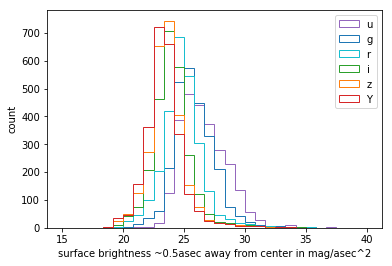

In [42]:
color_dict = {'u': 'tab:purple', 'g': 'tab:blue', 'r': 'tab:cyan', 'i': 'tab:green', 'z': 'tab:orange', 'Y': 'tab:red'}
for bp in 'ugrizY':
    #plt.hist(finite_sb_all_bands['mag_sb_%s' %bp], range=[20.0, 1000.0], histtype='step', facecolor=color_dict[bp], label=bp, bins=30)
    plt.hist(finite_sb_all_bands['mag_sb_%s' %bp], range=[15.0, 40.0], histtype='step', color=color_dict[bp], label=bp, bins=30)
plt.legend()
#plt.xlabel("surface brightness at SN location in mag/asec^2")
plt.xlabel("surface brightness ~0.5asec away from center in mag/asec^2")
plt.ylabel("count")

How far are the SNs from the host galaxy center? Seems far...

Text(0.5,0,'distance from SN to host center in arcsec')

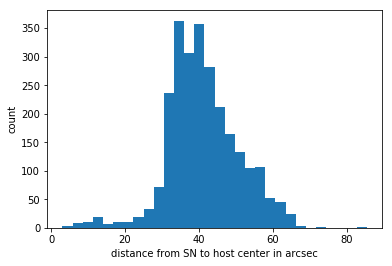

In [17]:
simple_join = hostgal.merge(sn_df, how='left', on='galaxy_id')
ra_host = simple_join['ra_true'].values
dec_host = simple_join['dec_true'].values
ra_sn = simple_join['snra_in'].values
dec_sn = simple_join['sndec_in'].values
angular_sep = angularSeparation(ra_host, dec_host, ra_sn, dec_sn) # deg
_ = plt.hist(units.deg_to_arcsec(angular_sep), bins=30)
plt.ylabel("count")
plt.xlabel("distance from SN to host center / hlr of host")
plt.ylabel("count")
plt.xlabel("distance from SN to host center in arcsec")

How many HLRs away from the host center are the SNs?
Too many... problem!

Text(0.5,0,'distance from SN to host center / hlr of host')

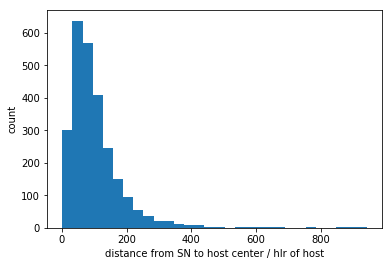

In [18]:
_ = plt.hist(units.deg_to_arcsec(angular_sep)/simple_join['size_true'].values, bins=30)
plt.ylabel("count")
plt.xlabel("distance from SN to host center / hlr of host")

Host magnitude for reference

Text(0,0.5,'count')

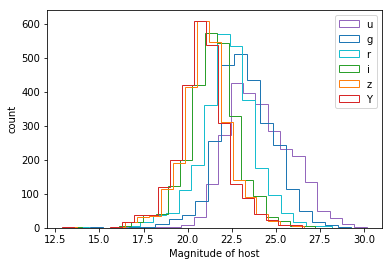

In [43]:
for bp in 'ugrizY':
    plt.hist(simple_join['mag_true_%s_lsst' %bp], histtype='step', color=color_dict[bp], label=bp, bins=20)
    #plt.hist(finite_sb_all_bands['mag_sb_%s' %bp], range=[15.0, 40.0], histtype='step', facecolor=color_dict[bp], label=bp, bins=30)
plt.legend()
plt.xlabel("Magnitude of host")
plt.ylabel("count")

### 4. (Further check) Compare Sersic vs. MoG profiles without PSF